# Automating Flow Cytometry Data Analysis

**USD M.Sc. Applied Data Science Capstone Project** \
*Shiley-Marcos School of Engineering* \


Gabriella Rivera\
John Vincent Deniega \
Date: 7Nov2024 \


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vanguardfox/ADS599/blob/main/ADS599.ipynb)

Mount Google Drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Install packages:

In [1]:
#!pip install FlowCal
#!pip install flowio
#!pip install openTSNE
#!pip install umap-learn

Import libraries:

In [2]:
import FlowCal
import flowio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pandas as pd
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import umap
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

Handle Warnings

In [ ]:
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

## Training, Validation, and Test Data sets

**Cleaned data sets to be used for Model Development and Testings**

In [3]:
# Upload Dataset from Google Drive
#pbmc_clean = pd.read_csv(output_path)
pbmc_clean = pd.read_csv('pbmc_clean.csv')

# Display the shape of the DataFrame
print("Number of instances and features:", pbmc_clean.shape)

Number of instances and features: (1260083, 13)


In [4]:
pbmc_clean.columns

Index(['FSC-A', 'FSC-H', 'SSC-A', 'CD123 BB660', 'CD14 BV510', 'HLA-DR BV786',
       'Live Dead UV Blue', 'CD20 BUV805', 'CD11c APC', 'CD45RA Ax700',
       'CD3 APC-H7', 'CD19 PE-Cy5', 'Time'],
      dtype='object')

In [5]:
# Split the dataset into training + validation and test sets
train_val, test = train_test_split(pbmc_clean, test_size=0.2, random_state=42)  # 20% for test

# Now split the training + validation set into training and validation sets
train, val = train_test_split(train_val, test_size=0.25, random_state=42)       # 25% of 80% is 20%

# - train: 60% of the original data
# - val: 20% of the original data
# - test: 20% of the original data

## Reduce Dimensionality

### PCA (Principal Component Analysis) - Most basic

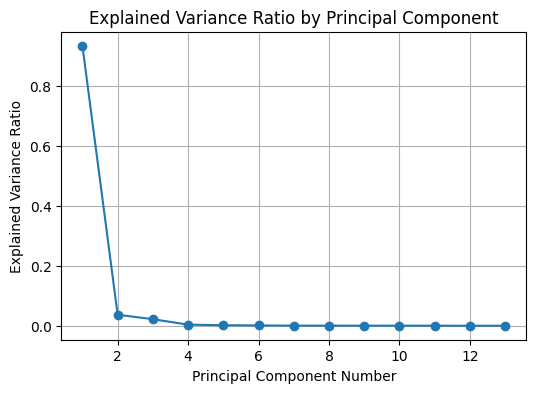

In [6]:
# Fit PCA on the training data
pca = PCA().fit(train)

# Plot the explained variance ratio
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance Ratio by Principal Component')
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()

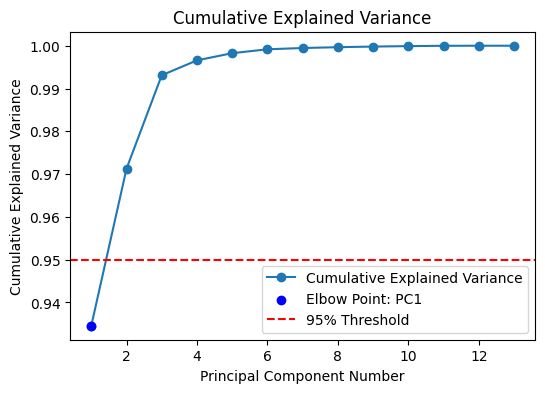

In [7]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the elbow point
# Calculate the difference in the cumulative variance to find the point of maximum change
diff = np.diff(cumulative_variance)
elbow_point = np.argmax(diff) + 1

# Plot the cumulative explained variance
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cumulative_variance) + 1),
         cumulative_variance,
         marker='o',
         label='Cumulative Explained Variance')

# Add the elbow point to the plot
plt.scatter(elbow_point, cumulative_variance[elbow_point - 1], color='b', zorder=5, label=f'Elbow Point: PC{elbow_point}')

# Add 95% threshold line
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')

# Titles and labels
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component Number')
plt.ylabel('Cumulative Explained Variance')

# Show the legend and grid
plt.legend()
plt.show()

PCA Train, Val, and Test Dataframes

In [8]:
# Record start time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

# Perform PCA with 3 components
pca = PCA(n_components=3)
train_pca = pca.fit_transform(train)
val_pca = pca.transform(val)
test_pca = pca.transform(test)

# Convert PCA results to DataFrame for easier plotting
train_pca_df = pd.DataFrame(data=train_pca, columns=['PC1', 'PC2','PC3'])
val_pca_df = pd.DataFrame(data=val_pca, columns=['PC1', 'PC2', 'PC3'])
test_pca_df = pd.DataFrame(data=test_pca, columns=['PC1', 'PC2', 'PC3'])

# Record end time
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")

# Calculate the total duration
duration = end_time - start_time
print(f"Total Duration: {duration}")

Start Time: 2024-11-23 13:01:39.319497
End Time: 2024-11-23 13:01:39.394398
Total Duration: 0:00:00.074901


In [9]:
# Combine the data into one DataFrame for easy plotting
#train_pca_df['Set'] = 'Training set'
#val_pca_df['Set'] = 'Validation set'
#test_pca_df['Set'] = 'Test set'

# Sample random points from the combined dataset for visualization
#sampled_df = train_pca_df.sample(n=100000, random_state=42)

# Create the interactive 3D plot with the sampled data
#fig = px.scatter_3d(sampled_df, x='PC1', y='PC2', z='PC3', color = 'PC3',
#                    labels={'PC1': 'PC 1',
#                            'PC2': 'PC 2',
#                            'PC3': 'PC 3'},
#                    title='Training Set: PCA of Flow Cytometry Data')

# Show the plot
#fig.show()

### openTSNE (Optimized for larger datasets)


In [10]:
from openTSNE import TSNE # Import here rather than earlier since TSNE has conflict above

In [11]:
# Record start time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

# Set n_components=2
open_tsne = TSNE(n_components=2, perplexity=30, n_jobs=-1, random_state=42)

sample_size = 100000  # Adjust the sample size as needed

# Fit the t-SNE model to PCA-transformed data
train_tsne = open_tsne.fit(train_pca[:sample_size])
val_tsne = open_tsne.fit(val_pca[:sample_size])
test_tsne = open_tsne.fit(test_pca[:sample_size])

# Create DataFrames with TSNE results
train_tsne_df = pd.DataFrame(train_tsne, columns=['TSNE1', 'TSNE2'])
val_tsne_df = pd.DataFrame(val_tsne, columns=['TSNE1', 'TSNE2'])
test_tsne_df = pd.DataFrame(test_tsne, columns=['TSNE1', 'TSNE2'])

# Record end time
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")

# Calculate the total duration
duration = end_time - start_time
print(f"Total Duration: {duration}")

Start Time: 2024-11-23 13:01:46.221307
End Time: 2024-11-23 13:06:03.983682
Total Duration: 0:04:17.762375


In [12]:
# Record start time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

# Scale the features before applying GMM
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train_tsne_df)

# Record end time
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")

# Calculate the total duration
duration = end_time - start_time
print(f"Total Duration: {duration}")

Start Time: 2024-11-23 13:06:03.988867
End Time: 2024-11-23 13:06:03.996000
Total Duration: 0:00:00.007133


## Model Development

### Model 1 - Gaussian Mixture Model

After exploring the BIC scores across a range of 200 components, the optimal cluster count was found to be 183, as it yielded the lowest BIC score. Both the 125 and 185 cluster solutions were visualized and identified as overfitted. They fragmented the data too much.

In [41]:
# # Find the optimal number of components at 200
# bic_scores = []
# for n_components in range(1, 200):
#     gmm = GaussianMixture(n_components=n_components, covariance_type='full',
#                           random_state=42,init_params='kmeans')
#     gmm.fit(scaled_features)
#     bic_scores.append(gmm.bic(scaled_features))

# # Plot BIC scores
# plt.plot(range(1, 200), bic_scores)
# plt.title('BIC for different number of components')
# plt.xlabel('Number of Components')
# plt.ylabel('BIC')
# plt.show()

# optimal_components = bic_scores.index(min(bic_scores)) + 1
print("Optimal number of components:", 183)

Optimal number of components: 183


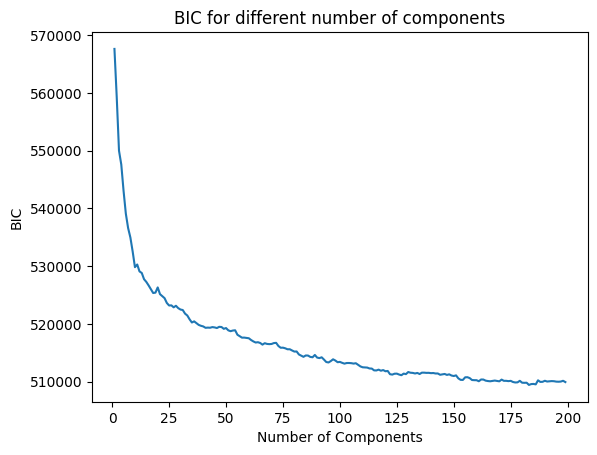

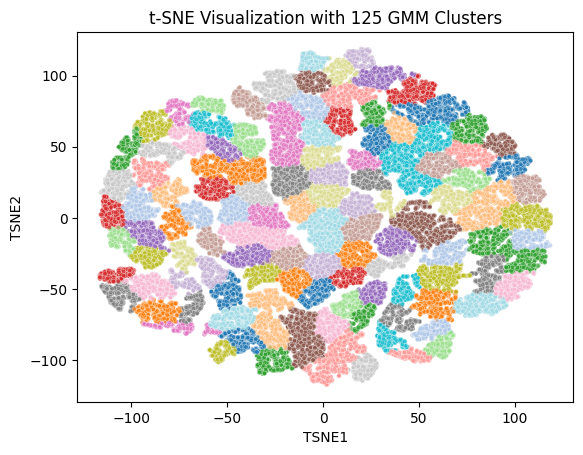

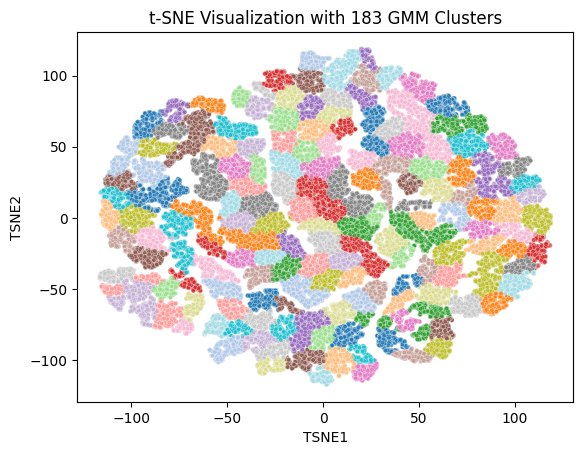

Using just 18 components proved sufficient to achieve a robust clustering solution that is neither overfitted nor underfitted.

Start Time: 2024-11-23 13:08:15.379858


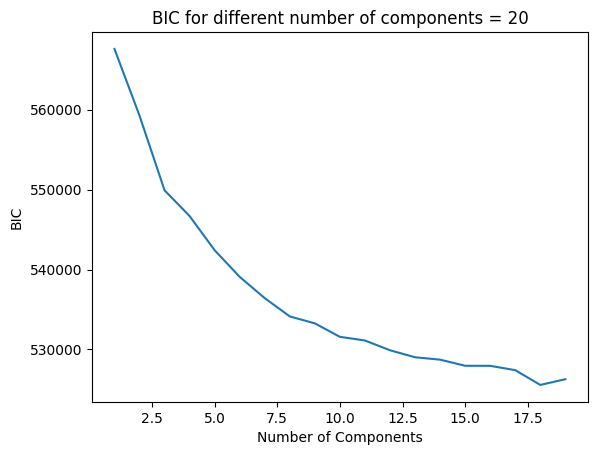

Optimal number of components: 18
End Time: 2024-11-23 13:08:24.136498
Total Duration: 0:00:08.756640


In [14]:
# Record start time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

# Find the optimal number of components at 20
bic_scores = []
for n_components in range(1, 20):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full',
                          random_state=42,init_params='kmeans')
    gmm.fit(scaled_features)
    bic_scores.append(gmm.bic(scaled_features))

# Plot BIC scores
plt.plot(range(1, 20), bic_scores)
plt.title('BIC for different number of components = 20')
plt.xlabel('Number of Components')
plt.ylabel('BIC')
plt.show()

optimal_components = bic_scores.index(min(bic_scores)) + 1
print("Optimal number of components:", optimal_components)

# Record end time
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")

# Calculate the total duration
duration = end_time - start_time
print(f"Total Duration: {duration}")

Start Time: 2024-11-23 13:08:28.307298


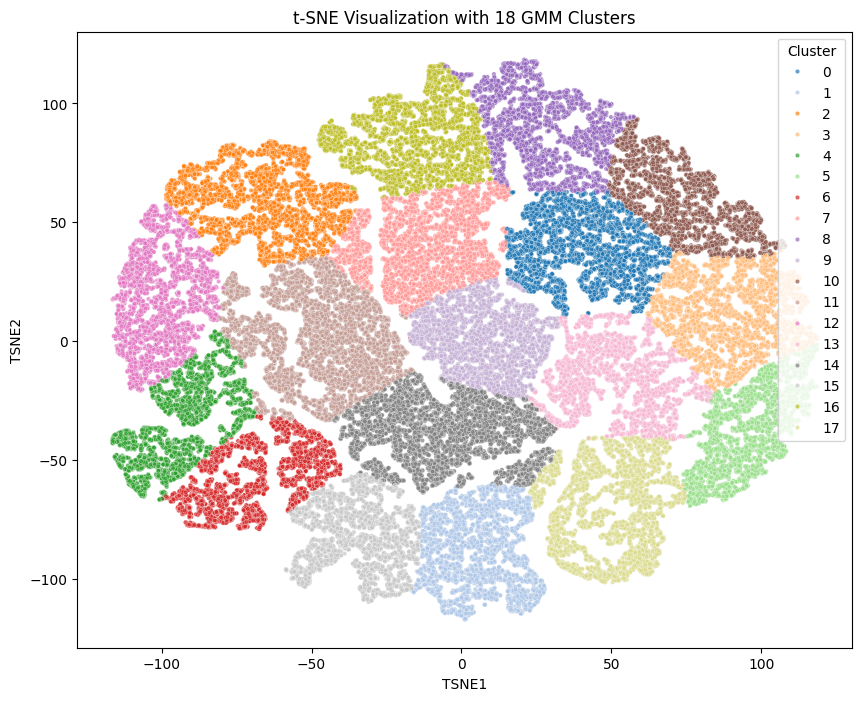

End Time: 2024-11-23 13:08:30.417944
Total Duration: 0:00:02.110646


In [15]:
# Record start time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

# Fit the GMM model with the optimal number of components
gmm = GaussianMixture(n_components=optimal_components, covariance_type='full',
                      random_state=42, init_params='kmeans')
gmm_labels = gmm.fit_predict(scaled_features)

# Add the cluster labels to the DataFrame
train_tsne_df['Cluster'] = gmm_labels

# Plot all clusters first
plt.figure(figsize=(10, 8))

# Visualize the clusters
sns.scatterplot(x=train_tsne_df['TSNE1'], y=train_tsne_df['TSNE2'],
                hue=train_tsne_df['Cluster'], palette='tab20',
                s=10, alpha=0.7)
plt.title("t-SNE Visualization with 18 GMM Clusters")
plt.show()

# Reset index for merging
train_reset = train.reset_index(drop=True)

# Merge original training set with the t-SNE cluster labels
train_with_clusters = pd.concat([train_reset, train_tsne_df[['Cluster']]], axis=1)

# Record end time
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")

# Calculate the total duration
duration = end_time - start_time
print(f"Total Duration: {duration}")

Select the clusters that have 50% of its population on high SSC-A region to capture cell size between Monocytes and Granolucytes.

In [16]:
# Record start time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

# Define threshold for SSC-A to identify high values
ssc_threshold = 1000

# Calculate the total number of cells per cluster
total_cells_per_cluster = train_with_clusters.groupby('Cluster').size()

# Calculate the number of cells in each cluster that meet the SSC-A threshold
cells_in_region = train_with_clusters[
    (train_with_clusters['SSC-A'] > ssc_threshold)
].groupby('Cluster').size()

# Calculate the proportion of cells per cluster that meet the criteria
proportion_in_region = cells_in_region / total_cells_per_cluster

# Set a threshold for selecting clusters based on the proportion of cells in the desired region
selection_threshold = 0.5

# Identify clusters that meet the selection threshold
selected_clusters = proportion_in_region[proportion_in_region >= selection_threshold].index

# Select the corresponding data for these clusters
selected_data = train_with_clusters[train_with_clusters['Cluster'].isin(selected_clusters)]

# Record end time
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")

# Calculate the total duration
duration = end_time - start_time
print(f"Total Duration: {duration}")

Start Time: 2024-11-23 13:08:56.330308
End Time: 2024-11-23 13:08:56.364471
Total Duration: 0:00:00.034163


Start Time: 2024-11-23 13:09:02.323058


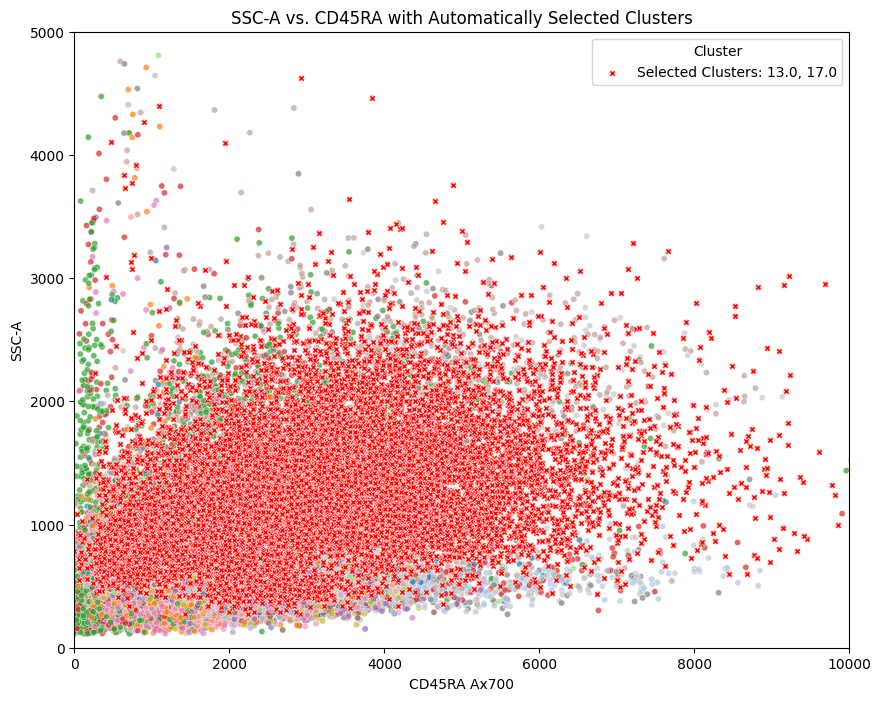

Automatically selected clusters based on SSC-A: Index([13.0, 17.0], dtype='float64', name='Cluster')
End Time: 2024-11-23 13:09:03.307852
Total Duration: 0:00:00.984794


In [17]:
# Record start time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

# Plot all clusters first
plt.figure(figsize=(10, 8))

sns.scatterplot(data=train_with_clusters,
                x='CD45RA Ax700',
                y='SSC-A',
                hue='Cluster',
                palette='tab20',
                s=20,
                alpha=0.7,
                legend=None)

# Overlay the selected clusters
sns.scatterplot(data=selected_data,
                x='CD45RA Ax700',
                y='SSC-A',
                color='red',
                s=20,
                label=f'Selected Clusters: {", ".join(map(str, selected_clusters))}',
                marker='X',
                alpha=1)

# Add labels and title
plt.xlabel("CD45RA Ax700")
plt.ylabel("SSC-A")
plt.xlim(0, 10000)
plt.ylim(0, 5000)
plt.title("SSC-A vs. CD45RA with Automatically Selected Clusters")

# Add legend for selected clusters
plt.legend(title="Cluster", loc='best')

# Show the plot
plt.show()

# Print the selected clusters and their counts
print(f"Automatically selected clusters based on SSC-A: {selected_clusters}")

# Record end time
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")

# Calculate the total duration
duration = end_time - start_time
print(f"Total Duration: {duration}")

Example of cluster below SSC-A region.

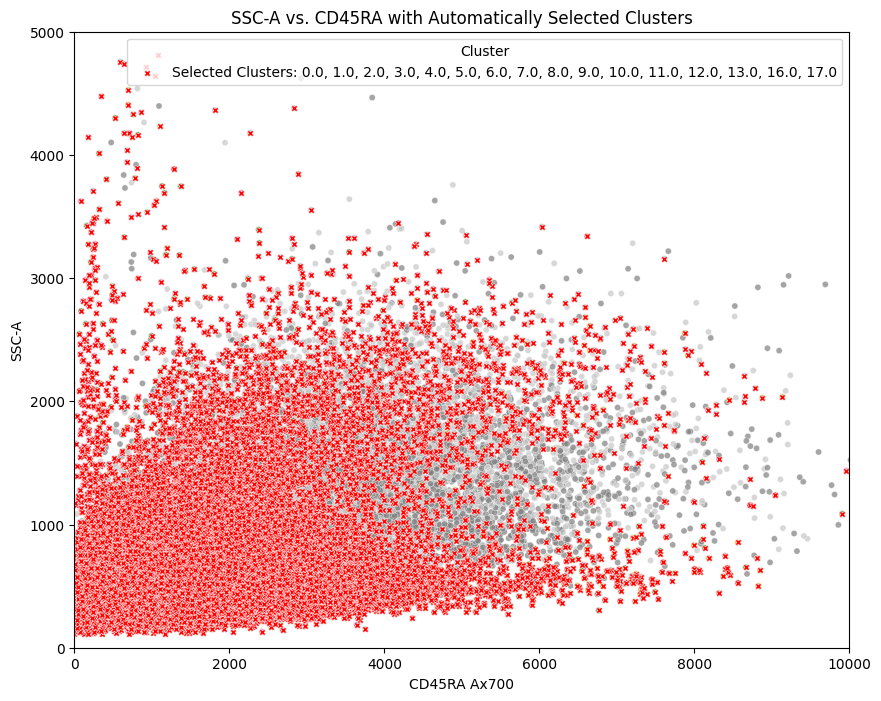

In [18]:
# Record start time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

# Calculate the total number of cells in the dataset
total_cells = len(train_with_clusters)

# Initialize list to hold results
results = []

# Loop through each selected cluster and count cells
for cluster in selected_clusters:
    cluster_cells = selected_data[selected_data['Cluster'] == cluster]
    cell_count = len(cluster_cells)
    proportion = cell_count / total_cells * 100

    # Append results
    results.append({
        'Cluster': cluster,
        'Cell Count': f"{cell_count:,}",
        'Proportion (%)': f"{proportion:.2f}"
    })

# Create a DataFrame for the results
results_df = pd.DataFrame(results)

# Add a combined row for all selected clusters
combined_count = results_df['Cell Count'].apply(lambda x: int(x.replace(',', ''))).sum()
combined_proportion = results_df['Proportion (%)'].apply(lambda x: float(x)).sum()
combined_row = pd.DataFrame([{
    'Cluster': 'Selected Clusters (Combined)',
    'Cell Count': f"{combined_count:,}",
    'Proportion (%)': f"{combined_proportion:.2f}"
}])

# Add the total cells row
total_cells_row = pd.DataFrame([{
    'Cluster': 'Total Cells',
    'Cell Count': f"{total_cells:,}",
    'Proportion (%)': "100.00"
}])

# Concatenate all rows
final_results = pd.concat([results_df, combined_row, total_cells_row], ignore_index=True)
print(final_results)

# Record end time
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")

# Calculate the total duration
duration = end_time - start_time
print(f"Total Duration: {duration}")

Start Time: 2024-11-23 13:09:16.750573
                        Cluster Cell Count Proportion (%)
0                          13.0      5,344           0.71
1                          17.0      6,058           0.80
2  Selected Clusters (Combined)     11,402           1.51
3                   Total Cells    756,049         100.00
End Time: 2024-11-23 13:09:16.762973
Total Duration: 0:00:00.012400


In [19]:
selected_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11402 entries, 2 to 99989
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   FSC-A              11402 non-null  float64
 1   FSC-H              11402 non-null  float64
 2   SSC-A              11402 non-null  float64
 3   CD123 BB660        11402 non-null  float64
 4   CD14 BV510         11402 non-null  float64
 5   HLA-DR BV786       11402 non-null  float64
 6   Live Dead UV Blue  11402 non-null  float64
 7   CD20 BUV805        11402 non-null  float64
 8   CD11c APC          11402 non-null  float64
 9   CD45RA Ax700       11402 non-null  float64
 10  CD3 APC-H7         11402 non-null  float64
 11  CD19 PE-Cy5        11402 non-null  float64
 12  Time               11402 non-null  float64
 13  Cluster            11402 non-null  float64
dtypes: float64(14)
memory usage: 1.3 MB


Now, take the selected clusters and plot into HLA-DR vs CD3.

Start Time: 2024-11-23 13:09:27.500972


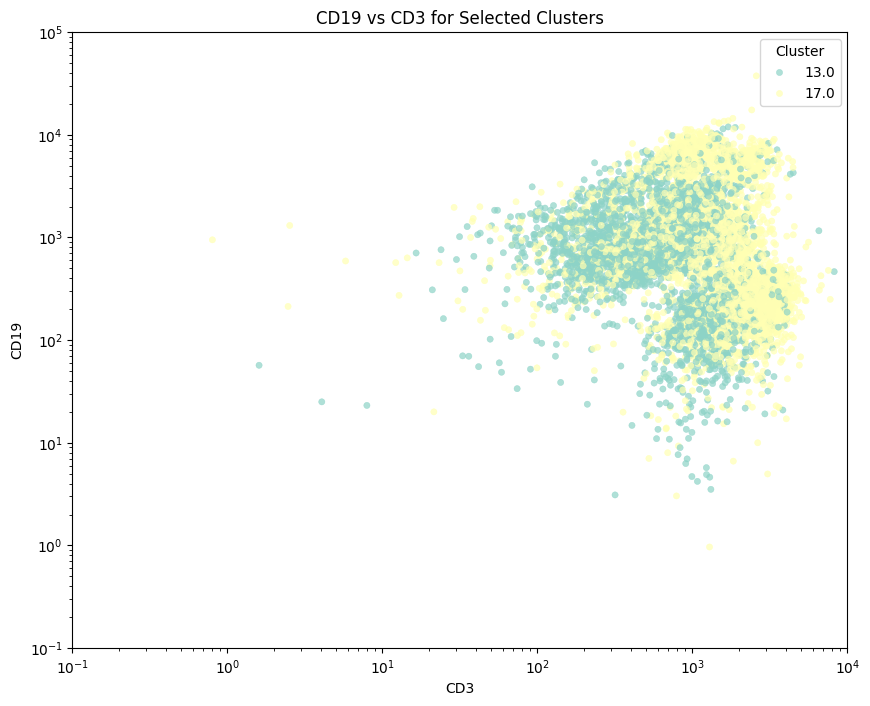

Automatically selected clusters based on SSC-A threshold: Index([13.0, 17.0], dtype='float64', name='Cluster')
End Time: 2024-11-23 13:09:27.852480
Total Duration: 0:00:00.351508


In [20]:
# Record start time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

# Create the plot
plt.figure(figsize=(10, 8))

# Plot Scatterplot
sns.scatterplot(
    data=selected_data,
    x='CD3 APC-H7',
    y='CD19 PE-Cy5',
    hue='Cluster',
    palette='Set3',
    s=20,
    alpha=0.7,
    edgecolor=None
)

# Add labels and title
plt.xlabel('CD3')
plt.ylabel('CD19')
plt.title('CD19 vs CD3 for Selected Clusters')

# Apply log scale to both axes
plt.xscale('log')
plt.yscale('log')

# Set axis limits
plt.xlim(0.1, 10000)
plt.ylim(0.1, 100000)

# Add a legend to indicate which color corresponds to which cluster
plt.legend(title="Cluster", loc='best')

# Show the plot
plt.show()

# Print the selected clusters for reference
print(f"Automatically selected clusters based on SSC-A threshold: {selected_clusters}")

# Record end time
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")

# Calculate the total duration
duration = end_time - start_time
print(f"Total Duration: {duration}")

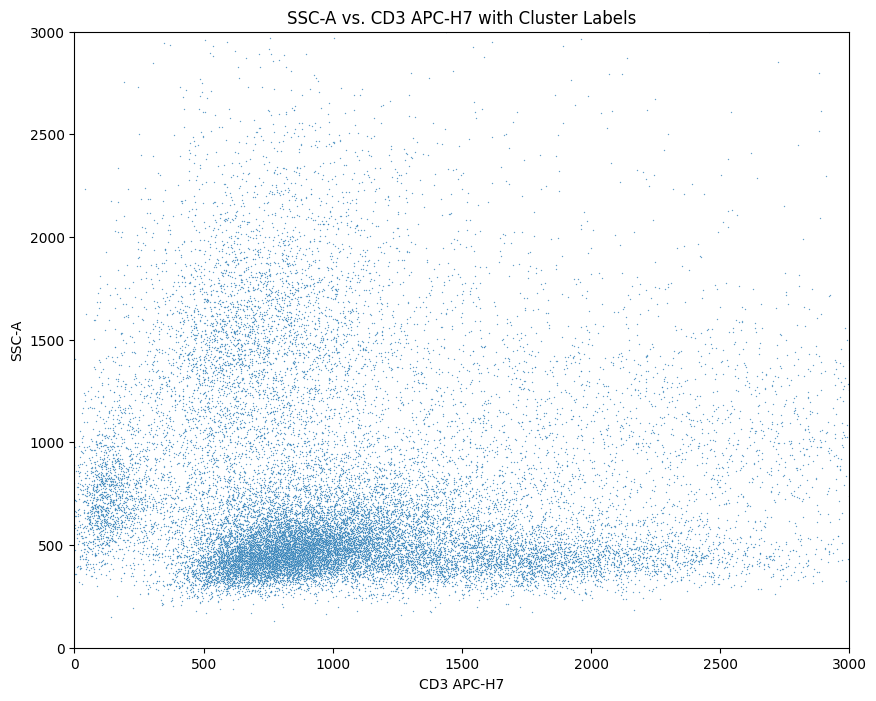

In [ ]:
# Plot "SSC-A" vs. "CD3 APC-H7" colored by cluster
plt.figure(figsize=(10, 8))
sns.scatterplot(data=cluster1,
                x='CD3 APC-H7',
                y='SSC-A',
                palette='Set1',
                s=1,
                alpha=0.7
)

plt.xlabel("CD3 APC-H7")
plt.ylabel("SSC-A")
plt.xlim(0, 3000)
plt.ylim(0, 3000)
plt.title("SSC-A vs. CD3 APC-H7 with Cluster Labels")
plt.show()

In [ ]:
cluster0 = cluster0.drop('Cluster', axis=1, inplace=True)

In [ ]:
cluster1.head()

,FSC-A,FSC-H,SSC-A,CD123 BB660,CD14 BV510,HLA-DR BV786,Live Dead UV Blue,CD20 BUV805,CD11c APC,CD45RA Ax700,CD3 APC-H7,CD19 PE-Cy5,Time,Cluster
4,161110.940,83526.15,834.9262,240.9422,222.4482,1811.1492,381.8828,510.5118,191.6737,3966.1230,4188.8910,202.5607,190.9942,1.0
8,62646.973,57678.83,499.3855,194.3904,141.3488,944.4211,182.2575,575.3004,139.3981,3215.3796,2649.0800,86.9875,16.6483,1.0
9,71670.150,64932.84,713.6741,146.6056,206.0998,209.8639,185.1683,22.0208,50.0779,1756.5591,587.1951,197.6788,166.2274,1.0
11,64092.730,56227.94,971.4736,125.4979,274.4529,709.7242,277.8881,219.0292,528.5879,2164.8132,1396.4130,157.2733,133.0391,1.0
12,71718.050,65861.58,302.3079,8404.7110,277.9987,12199.2240,322.7217,3679.0576,1768.0796,1517.8704,721.3344,5068.1396,40.6251,1.0


In [ ]:
# Perform PCA with 3 components

pca = PCA(n_components=3)
filtered_pca = pca.fit_transform(cluster1)

# Convert PCA results to DataFrame for easier plotting
filtered_pca_df = pd.DataFrame(data=filtered_pca, columns=['PC1', 'PC2','PC3'])

open_tsne = TSNE(n_components=2, perplexity=50, n_jobs=-1, random_state=42)


tsne = open_tsne.fit(train_pca)
tsne_df = pd.DataFrame(train_tsne, columns=['TSNE1', 'TSNE2'])



cluster_count = 3
gmm_filtered = GaussianMixture(n_components=cluster_count, random_state=42)
gmm_filtered_labels = gmm_filtered.fit_predict(train_tsne_df[['TSNE1', 'TSNE2']])

train_tsne_df['Cluster'] = gmm_labels

# Reset index of train set to for merging
train_reset = train.reset_index(drop=True)

# Merge the original training set data with the t-SNE cluster labels
train_with_clusters = pd.concat([train_reset, train_tsne_df[['Cluster']]], axis=1)

In [ ]:
# Calculate x_gate and y_gate based on cluster means in the original dimensions like with labels
cluster_means = (
    train_with_clusters.groupby('Cluster')[['CD3 APC-H7', 'CD19 PE-Cy5']].mean()
)

x_gate = cluster_means['CD3 APC-H7'].mean()  # Dynamic gate for CD3 APC-H7
y_gate = cluster_means['CD19 PE-Cy5'].mean()  # Dynamic gate for CD19 PE-Cy5

print(f"x_gate: {x_gate}, y_gate: {y_gate}")

In [ ]:
# Plot "CD19 PE-Cy5" vs. "CD3 APC-H7" colored by cluster
plt.figure(figsize=(10, 8))

sns.scatterplot(data=train_with_clusters,
                x='CD3 APC-H7',
                y='CD19 PE-Cy5',
                hue='Cluster',
                palette='viridis',
                s=10,
                alpha=0.7)

# Add gates as dashed lines
plt.axvline(x=x_gate, color='black', linestyle='--', label=f'x_gate: {x_gate:.2f}')
plt.axhline(y=y_gate, color='black', linestyle='--', label=f'y_gate: {y_gate:.2f}')
# Set logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Set tick marks at every power of 10
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0))
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0))

plt.xlim(1, 100000)  # Ensure the range starts at 1 (log cannot be zero)
plt.ylim(1, 100000)

plt.xlabel("CD3 APC-H7")
plt.ylabel("CD19 PE-Cy5")
plt.title("CD19 PE-Cy5 vs. CD3 APC-H7 with Cluster Labels and Gates")
plt.legend(title="Cluster", loc='best')
plt.show()

In [ ]:
# Define the function to assign names based on quadrant logic
def assign_cluster_label(x, y, x_gate, y_gate, x_label, y_label):
    if x > x_gate and y > y_gate:
        return f"{x_label} +, {y_label} +"  # Q2
    elif x <= x_gate and y > y_gate:
        return f"{y_label} +"  # Q1
    elif x > x_gate and y <= y_gate:
        return f"{x_label} +"  # Q3
    elif x <= x_gate and y <= y_gate:
        return f"{x_label} -, {y_label} -"  # Q4
    else:
        return "Unassigned"  # Handles edge cases (if any)

# Label centroids by their quadrant location
centroids['Cluster Label'] = centroids.apply(
    lambda row: assign_cluster_label(
        row['CD3 APC-H7'],
        row['CD19 PE-Cy5'],
        x_gate,
        y_gate,
        "CD3 APC-H7",
        "CD19 PE-Cy5"
    ),
    axis=1
)

# Map cluster IDs to descriptive labels
cluster_labels = {row['Cluster']: f"Cluster {int(row['Cluster'])} ({row['Cluster Label']})" for _, row in centroids.iterrows()}

# Update the labels in the DataFrame to use for dotplotting
train_with_clusters['Cluster Label'] = train_with_clusters['Cluster'].map(cluster_labels)

# Plot "CD19 PE-Cy5" vs. "CD3 APC-H7" colored by updated cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(data=train_with_clusters,
                x='CD3 APC-H7',
                y='CD19 PE-Cy5',
                hue='Cluster Label',
                palette='Set1',
                s=10,
                alpha=0.7)

# Add gates as dashed lines
plt.axvline(x=x_gate, color='black', linestyle='--', label=f'x_gate: {x_gate:.2f}')
plt.axhline(y=y_gate, color='black', linestyle='--', label=f'y_gate: {y_gate:.2f}')

# Set logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Set tick marks at every power of 10
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0))
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0))

plt.xlim(1, 100000)
plt.ylim(1, 100000)
plt.xlabel("CD3 APC-H7")
plt.ylabel("CD19 PE-Cy5")
plt.title("CD19 PE-Cy5 vs. CD3 APC-H7 with Cluster Labels")
plt.legend(title="Cluster and Gates", loc='best')
plt.show()

In [ ]:
# Define quadrants based on gates
conditions = [
    (train_with_clusters['CD3 APC-H7'] > x_gate) & (train_with_clusters['CD19 PE-Cy5'] > y_gate),  # Q1
    (train_with_clusters['CD3 APC-H7'] <= x_gate) & (train_with_clusters['CD19 PE-Cy5'] > y_gate),  # Q2
    (train_with_clusters['CD3 APC-H7'] > x_gate) & (train_with_clusters['CD19 PE-Cy5'] <= y_gate),  # Q3
    (train_with_clusters['CD3 APC-H7'] <= x_gate) & (train_with_clusters['CD19 PE-Cy5'] <= y_gate),  # Q4
]
quadrant_labels = ['Q1', 'Q2', 'Q3', 'Q4']

# Assign each point a quadrant label
train_with_clusters['Quadrant'] = np.select(conditions, quadrant_labels, default='Unclassified')

# Check the quadrant assignment
print(train_with_clusters[['CD3 APC-H7', 'CD19 PE-Cy5', 'Cluster', 'Quadrant']].head())


### UMAP (Uniform Manifold Approximation and Projection) - Alternative to T-SNE, after passing through PCA

In [1]:
# Perform UMAP
umap_model = umap.UMAP(n_components=2, n_jobs=-1)
train_umap = umap_model.fit_transform(train_pca)
val_umap = umap_model.fit_transform(val_pca)
test_umap = umap_model.fit_transform(test_pca)

# Convert UMAP results to DataFrame for easier plotting
train_umap_df = pd.DataFrame(train_umap, columns=['UMAP1', 'UMAP2'])
val_umap_df = pd.DataFrame(val_umap, columns=['UMAP1', 'UMAP2'])
test_umap_df = pd.DataFrame(test_umap, columns=['UMAP1', 'UMAP2'])

NameError: name 'umap' is not defined

In [ ]:
# Sample random points from the combined dataset for visualization
sampled_df = train_umap_df.sample(n=500000, random_state=42)

# Create the interactive 3D plot with the sampled data
fig = px.scatter_3d(sampled_df, x='UMAP1', y='UMAP2', z='UMAP3', color = 'UMAP1',
                    labels={'UMAP1': 'UMAP 1',
                            'UMAP2': 'UMAP 2',
                            'UMAP3': 'UMAP 3'},
                    title='PCA + UMAP of Training Set (3D)')

# Show the plot
fig.show()

## TO-DO. Incremental PCA, Feature Agglomeration possible dimensionality reduction techniques

### Model 2 - DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

# Fit DBSCAN on the t-SNE data
dbscan = DBSCAN(eps=3, min_samples=10)
dbscan_labels = dbscan.fit_predict(train_tsne_df[['TSNE1', 'TSNE2']])

# Add the cluster labels to your DataFrame
train_tsne_df['Cluster'] = dbscan_labels


### Model 3 - Agglomerative Clustering

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis', s=10, alpha=0.7)
plt.title('t-SNE Clustering for Gating')
plt.legend(title='Cluster')
plt.show()


## Model Performance Evaluation and Model Selection

### Cummulative AUC-ROC Plot and Accuracy Table

In [ ]:
# Cummulative AUC-ROC Plot




In [ ]:
# Compiled Accuracy Table




## Model Testing: non-conventional sample

In [ ]:
# AUC-ROC Plot




# Tableau or FLASK Release

# References

1. Beckman Coulter. (2022). Automatic gating - Beckman Coulter. Flow Cytometry. [https://www.beckman.com/flow-cytometry/software/cytobank-premium/learning-center/automatic-gating](https://www.beckman.com/flow-cytometry/software/cytobank-premium/learning-center/automatic-gating)

2. FlowRepository. (2020). FlowRepository ID FR-FCM-Z32U. Retrieved from [http://flowrepository.org/experiments/3166/download_ziped_files](http://flowrepository.org/experiments/3166/download_ziped_files)

3. Hu, Z., Bhattacharya, S., & Butte, A. J. (2022). Application of Machine Learning for Cytometry Data. *Frontiers in Immunology*, 12, 787574. [https://doi.org/10.3389/fimmu.2021.787574](https://doi.org/10.3389/fimmu.2021.787574)

4. Mair, F., & Leichti, T. (2020). Comprehensive Phenotyping of Human Dendritic Cells and Monocytes. *Journal of Quantitative Cell Science*, 99(3), 231-242. [https://doi.org/10.1002/cyto.a.24269](https://doi.org/10.1002/cyto.a.24269)

5. Maecker, H. T., McCoy, J. P., & Nussenblatt, R. (2012). Standardizing immunophenotyping for the Human Immunology Project. *Nature Reviews Immunology*, 12(3), 191–200. [https://doi.org/10.1038/nri3158](https://doi.org/10.1038/nri3158)

6. Ng, D. P., Simonson, P. D., Tarnok, A., Lucas, F., Kern, W., Rolf, N., Bogdanoski, G., Green, C., Brinkman, R. R., & Czechowska, K. (2024). Recommendations for using artificial intelligence in clinical flow cytometry. *Cytometry Part B: Clinical Cytometry*, 106(4), 228–238. [https://doi.org/10.1002/cyto.b.22166](https://doi.org/10.1002/cyto.b.22166)
